In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.metrics import adapted_rand_error
from sklearn.metrics import precision_score, recall_score
from tifffile import imwrite, imsave
import datetime
from numba import jit, njit, prange
from functools import partial
import time 
import pandas as pd
from skimage.measure import label, regionprops, regionprops_table
import trackpy as tp
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import os.path
import matplotlib.pylab as pl
from os import listdir, chdir
from os.path import isfile
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

10/26/23 testing the segmentation accuracy again before putting it in the paper

In [2]:
@partial(jit, nopython=True)
def swap(x, t_args):
    return np.transpose(x, t_args)

@njit
def tile_image(imframe: np.ndarray, tilesize: tuple):
    """Takes a 2d array and returns an array of image tiles with shape (Y, X, n, m) where Y is the tile row number, X is the tile column
    number, n is the tile pixel height and m is the tile pixel width"""
    img_height, img_width = imframe.shape
    tileheight, tilewidth = tilesize
    imcopy = imframe.copy() #workaround for numba reshape not supporting non-contiguous arrays
    tiled_array = imcopy.reshape(img_height // tileheight, tileheight, img_width // tilewidth, tilewidth)
    out_array = swap(tiled_array,(0,2,1,3))
    return out_array

@njit
def reform_image(tilearray: np.ndarray, originalsize: tuple):
    """Reforms an image from a tile array with shape (Y, X, n, m) where Y is the tile row number, X is the tile column
    number, n is the tile pixel height and m is the tile pixel width.  Returns an image with the shape of the original imag"""
    
    reordered = swap(tilearray,(0,2,1,3))
    contiguous = reordered.copy() #numba doesn't support numpy reshaping of non-congiguous arrays so you have to copy it as a workaround
    reformed = contiguous.reshape(originalsize)
    return reformed

@njit
def linalg_test(solvematrix, zmatrix):
    coefs = np.linalg.lstsq(solvematrix, zmatrix)[0]
    return coefs

@njit
def plane_level_njit(img: np.ndarray):
    """Takes a 2d image (numpy array), calculates the mean plane, and returns that 2d image after subtracting the
    mean plane"""

    """Create x, y, and z (pixel intensity) arrays"""
    dimensions = img.shape
    totalpoints = dimensions[0] * dimensions[1]
    xarray = np.linspace(0, totalpoints - 1, totalpoints) % dimensions[0]
    yarray = np.linspace(0, dimensions[1] - 1, totalpoints)  # a sequence that makes y values that correspond to the z points
    flatimg = img.flatten()+0.0

    """Calculate the best fit plane through the datapoints"""
    cvals = xarray*0+1.0  #make the cvals floats

    xyc = np.column_stack((xarray, yarray, cvals))
    coefs = np.linalg.lstsq(xyc, flatimg)[0]  #njit and lstsq require all the datatypes to be the same

    leveled_flat = flatimg-((coefs[0]*xarray+coefs[1]*yarray+coefs[2])-np.mean(flatimg))

    final_img = leveled_flat.reshape(img.shape)
    return final_img

@njit
def median_prominence_threshold(imgarray, prominence):
    """Takes an input array and thresholds it using median + prominence"""
    brlevel = np.median(imgarray)
    threshold = brlevel + prominence
    thresholded = (imgarray > threshold)
    
    
    return thresholded

@njit
def min_prominence_threshold(imgarray, prominence):
    """Takes an input array and thresholds it using minimum + prominence"""
    brlevel = np.percentile(imgarray, 25)
    threshold = brlevel + prominence
    thresholded = (imgarray > threshold)
    
    
    return thresholded

@njit(parallel=True)
def batch_level_segment(image: np.array, tileshape: tuple, imageshape: tuple, threshold):
    """efficient numba implementation of a function that takes a 3d image as a np array, tiles it, levels it, 
    and segments it """
    segmented_timeseries = np.zeros(image.shape)

    for frameid in range(image.shape[0]):
        
        frame = image[frameid,:,:]
        tiles = tile_image(frame, tileshape)
        segmented = np.zeros(tiles.shape)

        for i in prange(tiles.shape[0]):
            for j in prange(tiles.shape[1]):
                tile = tiles[i,j,:,:]
                leveltile = plane_level_njit(tile)
                segmentedtile = median_prominence_threshold(leveltile,threshold)
                segmented[i,j,:,:] = segmentedtile


        reformed = reform_image(segmented, imageshape)
        segmented_timeseries[frameid,:,:] = reformed.astype(np.uint8)
        print(frameid)

    return segmented_timeseries

In [3]:
imdir = '/Users/apple/Sync/Research/NiCr XPEEM/Labeled Images/png images'
labeldir= '/Users/apple/Sync/Research/NiCr XPEEM/Labeled Images/png labels'

images = [f for f in listdir(imdir) if isfile(os.path.join(imdir, f)) and '.tif' in f]
labels = [f for f in listdir(labeldir) if isfile(os.path.join(labeldir, f)) and '.tif' in f]
images.sort()
labels.sort()
images = [os.path.join(imdir, f) for f in images]
labels = [os.path.join(labeldir, f) for f in labels]
print(images)

['/Users/apple/Sync/Research/NiCr XPEEM/Labeled Images/png images/Movie_20001_832_320.tif', '/Users/apple/Sync/Research/NiCr XPEEM/Labeled Images/png images/Movie_20008_640_768.tif', '/Users/apple/Sync/Research/NiCr XPEEM/Labeled Images/png images/Movie_20022_768_960.tif', '/Users/apple/Sync/Research/NiCr XPEEM/Labeled Images/png images/Movie_20036_960_832.tif', '/Users/apple/Sync/Research/NiCr XPEEM/Labeled Images/png images/Movie_20061_960_128.tif', '/Users/apple/Sync/Research/NiCr XPEEM/Labeled Images/png images/Movie_20077_128_896.tif', '/Users/apple/Sync/Research/NiCr XPEEM/Labeled Images/png images/Movie_20081_448_704.tif', '/Users/apple/Sync/Research/NiCr XPEEM/Labeled Images/png images/Movie_20086_768_512.tif', '/Users/apple/Sync/Research/NiCr XPEEM/Labeled Images/png images/Movie_20112_192_320.tif', '/Users/apple/Sync/Research/NiCr XPEEM/Labeled Images/png images/Movie_20137_0_192.tif', '/Users/apple/Sync/Research/NiCr XPEEM/Labeled Images/png images/Movie_20181_960_256.tif', 

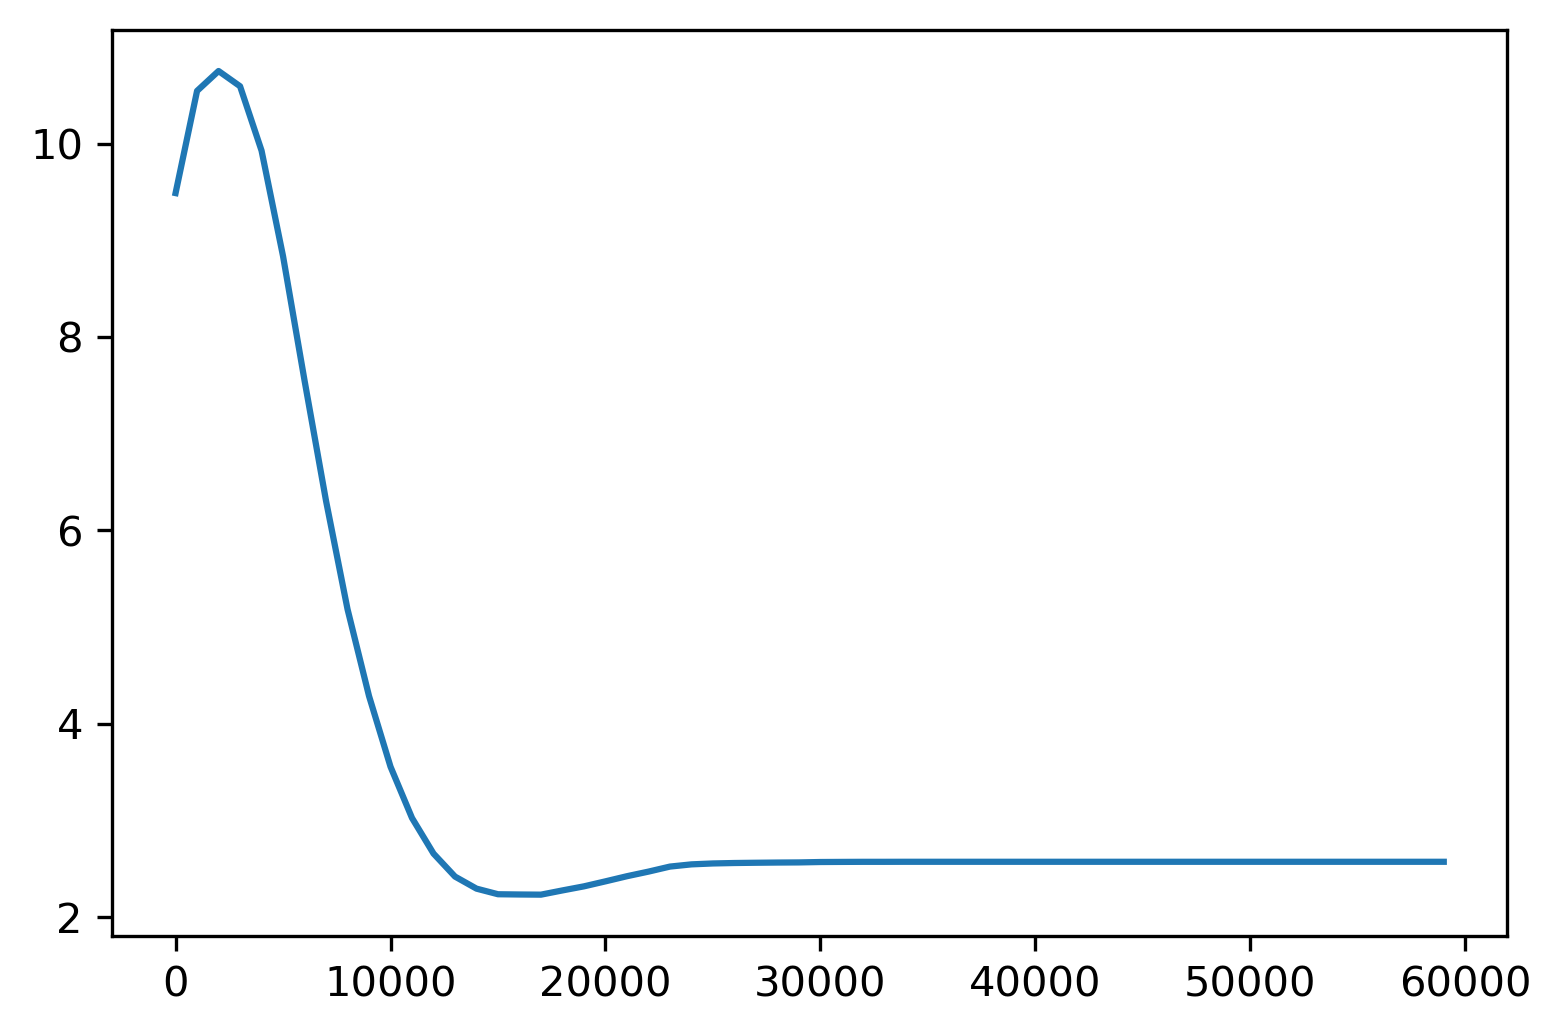

In [23]:
prominences = np.arange(0,60000,1000)/65536
errors = np.zeros((len(prominences),len(images)))
errorsums = np.zeros(prominences.shape)
precisionmin = np.zeros((len(prominences),len(images)))
recallmin = np.zeros((len(prominences),len(images)))

for p, prominence in enumerate(prominences):
    sum = 0
    for i, imname in enumerate(images):
        # if ".tif" not in imname:
        #     continue
        image = imread(images[i])
        label = imread(labels[i])
        if label.sum()<5:
            continue
        leveled = plane_level_njit(image)
        predicted = min_prominence_threshold(leveled, prominence)
        a = adapted_rand_error(label.astype(int), predicted.astype(int),ignore_labels=())
        errors[p,i] = a[0]
        precisionmin[p,i] = a[1]
        recallmin[p,i] = a[2]
        sum += a[0]
    errorsums[p] = sum

errorsframemin = pd.DataFrame(errors).fillna(1)
precisionframemin = pd.DataFrame(precisionmin).fillna(1)    
recallframemin = pd.DataFrame(recallmin).fillna(1)    
plt.plot(prominences*65536,np.sum(errorsframemin,axis=1))

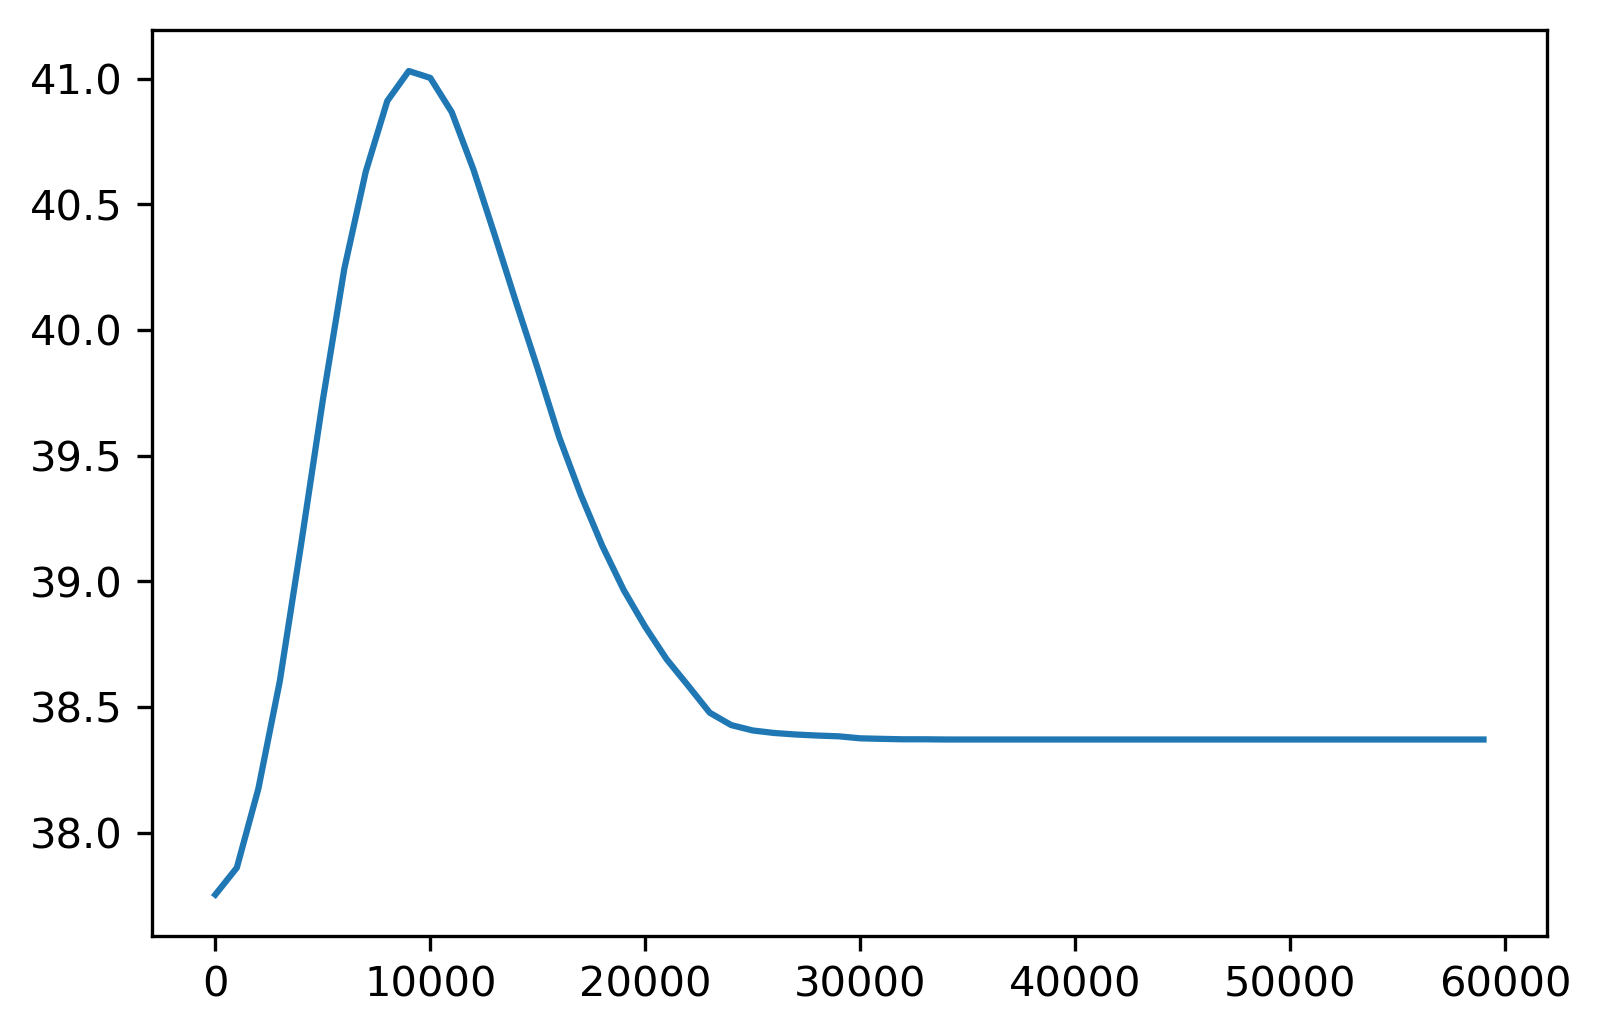

In [5]:
plt.plot(prominences*65535, np.sum(recallframemin,axis=1))

In [15]:
prominences = np.arange(1000,20000,200)/65536
errors = np.zeros((len(prominences),len(images)))
errorsums = np.zeros(prominences.shape)
precision64 = np.zeros((len(prominences),len(images)))
recall64 = np.zeros((len(prominences),len(images)))

for p, prominence in enumerate(prominences):
    sum = 0
    for i, imname in enumerate(images):

        image = imread(images[i])
        label = imread(labels[i])
        if label.sum() <5:
            continue
        leveled = plane_level_njit(image)
        predicted = median_prominence_threshold(leveled, prominence)
        a = adapted_rand_error(label.astype(int), predicted.astype(int),ignore_labels=())
        errors[p,i] = a[0]
        precision64[p,i] = a[1]
        recall64[p,i] = a[2]
        sum += a[0]
    errorsums[p] = sum

errorsframe = pd.DataFrame(errors)
errorsframe64 = errorsframe.fillna(1)
precisionframe64 = pd.DataFrame(precision64).fillna(1)    
recallframe64 = pd.DataFrame(recall64).fillna(1)    


In [16]:
errorsframe64.to_clipboard()

In [19]:
prominences = np.arange(1000,20000,200)/65536
errors = np.zeros((len(prominences),len(images)))
precision32 = np.zeros((len(prominences),len(images)))
recall32 = np.zeros((len(prominences),len(images)))
errorsums = np.zeros(prominences.shape)


for p, prominence in enumerate(prominences):
    sum = 0
    for i, imname in enumerate(images):

        image = imread(images[i])
        label = imread(labels[i])
        if label.sum() < 5:
            continue
        tiles = tile_image(image,(32,32))
        segmented = np.zeros(tiles.shape)
        for x in range(tiles.shape[0]):
            for y in range(tiles.shape[1]):
                level_tile = plane_level_njit(tiles[x,y,:,:])
                segmented[x,y,:,:] = median_prominence_threshold(level_tile, prominence)
        
        predicted = reform_image(segmented,(64,64))

        a = adapted_rand_error(label.astype(int), predicted.astype(int),ignore_labels=())
        errors[p,i] = a[0]
        precision32[p,i] = a[1]
        recall32[p,i] = a[2]
        sum += a[0]
    errorsums[p] = sum

errorsframe = pd.DataFrame(errors)
errorsframe32 = errorsframe.fillna(1)
precisionframe32 = pd.DataFrame(precision32).fillna(1)
recallframe32 = pd.DataFrame(recall32).fillna(1)


In [8]:
# image = imread(images[20])
# label = imread(labels[20])
# leveled = plane_level_njit(image)
# predicted = median_prominence_threshold(leveled, 1000/65536)
# print(leveled)

# a = adapted_rand_error(label.astype(int), predicted.astype(int))
# print(a)
# plt.imshow(label)
# print(imname)

Text(0, 0.5, 'Cumulative Sum')

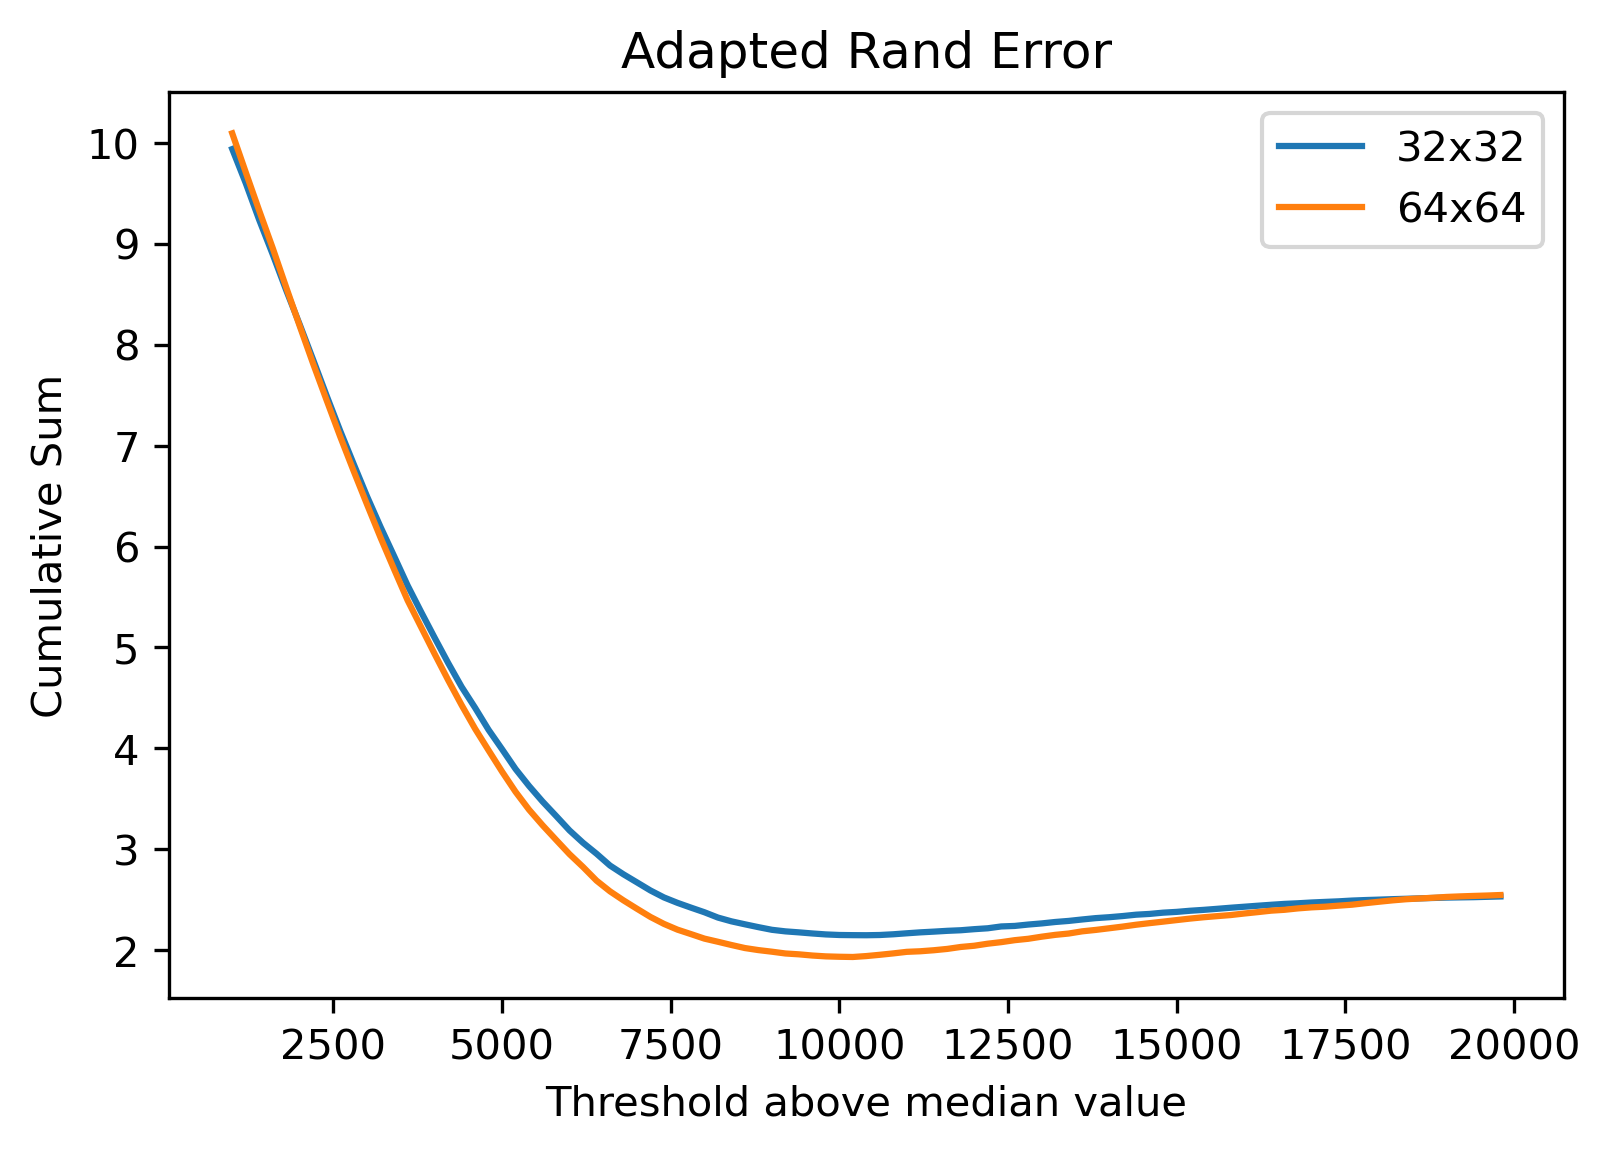

In [20]:
plt.plot(prominences*65536,np.sum(errorsframe32,axis=1))
plt.plot(prominences*65536,np.sum(errorsframe64,axis=1))
plt.legend(["32x32", "64x64"])
plt.xlabel("Threshold above median value")
plt.title("Adapted Rand Error")
plt.ylabel("Cumulative Sum")

Text(0, 0.5, 'Cumulative Sum')

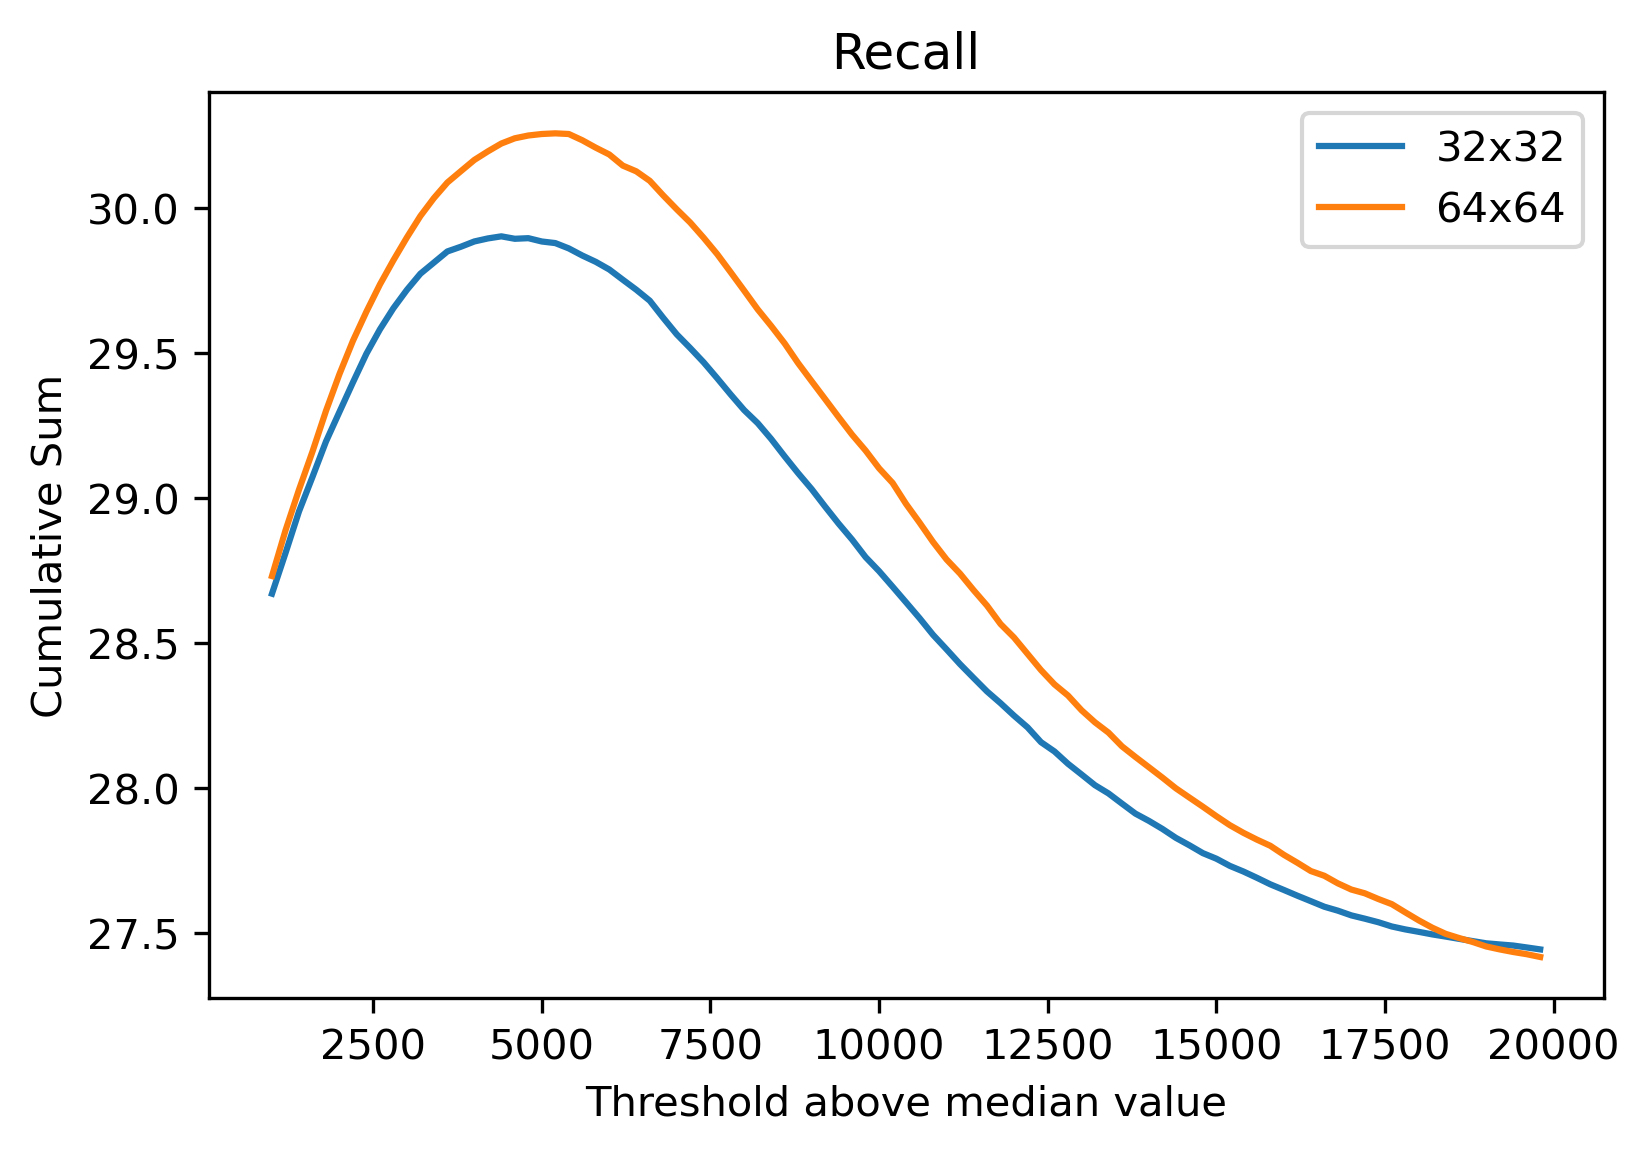

In [21]:
plt.plot(prominences*65536,np.sum(recallframe32,axis=1))
plt.plot(prominences*65536,np.sum(recallframe64,axis=1))
plt.legend(["32x32", "64x64"])
plt.title("Recall")
plt.xlabel("Threshold above median value")
plt.ylabel("Cumulative Sum")

Text(0, 0.5, 'Cumulative sum')

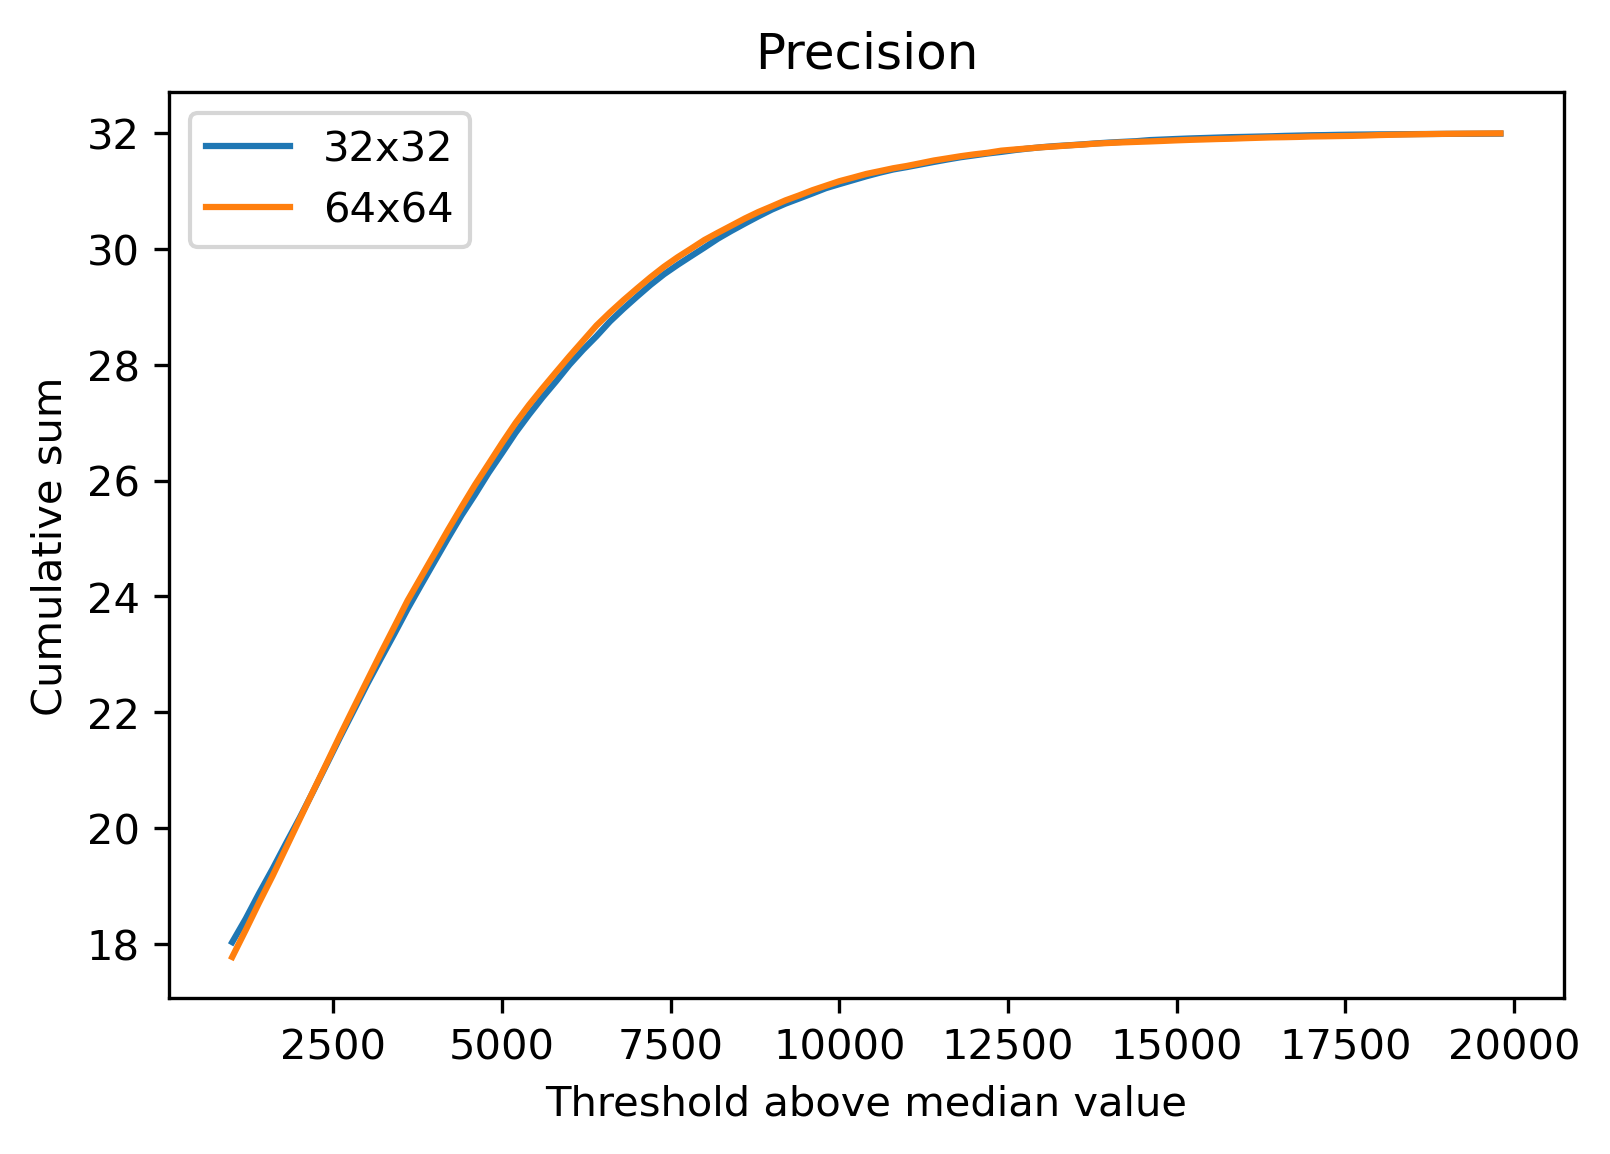

In [22]:
plt.plot(prominences*65536,np.sum(precision32,axis=1))
plt.plot(prominences*65536,np.sum(precisionframe64,axis=1))
plt.legend(["32x32", "64x64"])
plt.title("Precision")
plt.xlabel("Threshold above median value")
plt.ylabel("Cumulative sum")